# 1. Importing Libraries

In [37]:
# QML
import pennylane as qml

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split


# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
from pennylane import numpy as np

# 2. Exploring the data

### > Number of images/data

In [38]:
folder = "./data/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('./data/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

### > Number of samples per each label

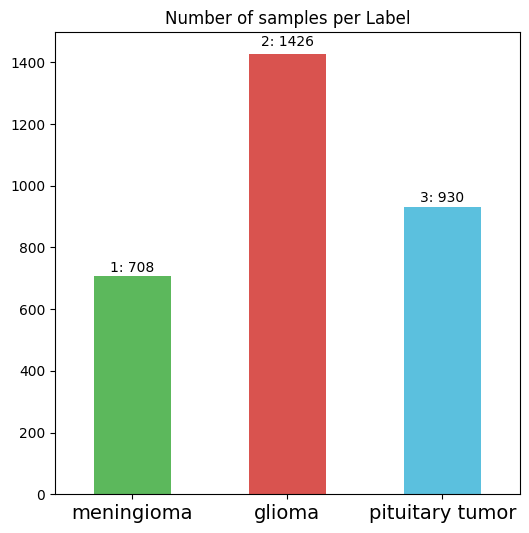

In [39]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#5cb85c', '#d9534f', '#5bc0de'],
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=0)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1


# 3. Creating a list of label, images and masks

In [4]:
folder = "./data/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

((3,), (3, 512, 512, 4), (3, 512, 512))

### > Let's visualize each tumor and where it appears in the brain

In [5]:
b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape

(3, 512, 512)


(3, 512, 512, 3)

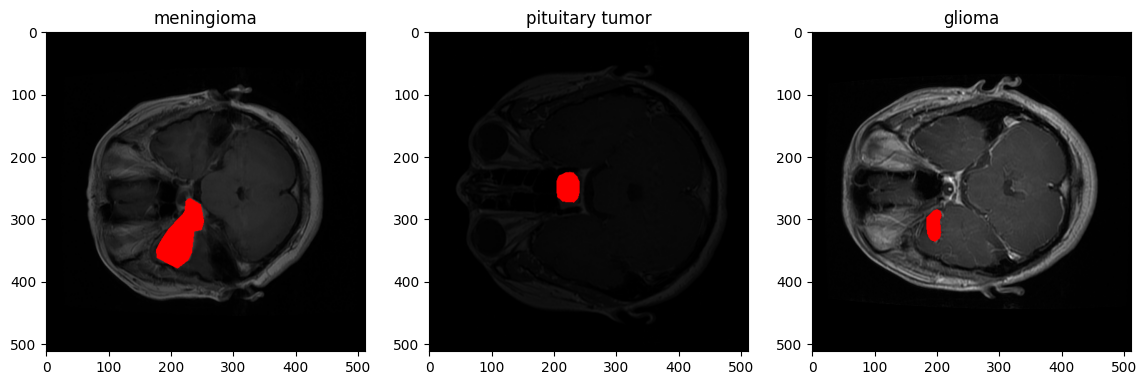

In [6]:
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])

plt.show()

# 4. Hybrid Quantum-Classical CNN model

**References**
1. https://pennylane.ai/qml/demos/tutorial_quanvolution.html?fbclid=IwAR3Sw-OvDokiY1bzltvyyLHnnlPvlVTnAiwH3HqjTYpLxnjSbibGBfaSmTA
2. https://arxiv.org/pdf/2009.09423.pdf

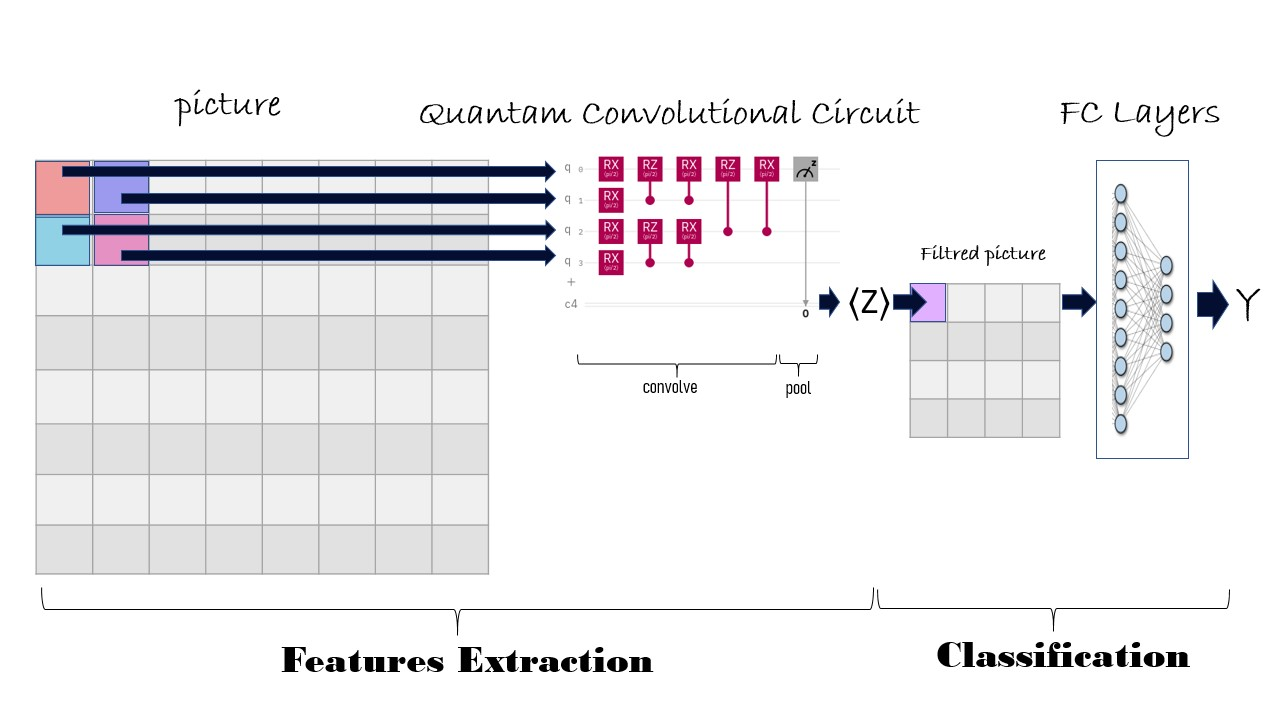

# 5. Feature Extraction 

**Steps**:
1. First we will create the desire quantum circuit as shown above.
2. Next we will take each image and embed in into the circuit. We perform some computation and measure the image, which will give us a list of classical expectation values
    

In [7]:
wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)

#quantum circuit
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])

    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))

    return measurement


#extracting features from the images
def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    H, W = X.shape
    step2 = 2
    out = np.zeros(((H//step), (W//step)))
    #progress = 0
    for i in range(0, W, step):
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # get 2x2 pixels and make them 1D array
            phi = X[i:i+2, j:j+2].flatten()
            # Get Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out

## Quantum Circuit

In [8]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))


0: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╭RZ(1.57)─╭RX(1.57)─┤  <Z>
1: ──RX(3.14)─╰●────────╰●────────│─────────│─────────┤     
2: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╰●────────╰●────────┤     
3: ──RX(3.14)─╰●────────╰●────────────────────────────┤     


## Processing the image using a Quantum Convolutional Layer

`Note`: This step will take 15 to 16 hrs, depending on your cpu.

If you don't want to wait for 16 hrs for processing the images, you can directly load the `QModel.h5` file and jump directly to Confusion Matrix section.

In [14]:
folder = "./data/" # .mat files folder
processFolder = "./processed/"
start = timer()
w = 512
step = 2

k = 0
directs = sorted(listdir(folder))

for file in directs:
    all64 = sorted(listdir(processFolder))
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    NorImages = resized/255

    processed = QCONV1(NorImages, str(k)+" "+file, (len(directs)-len(all64))/2, step)

    np.savez_compressed(processFolder+file, image=processed, label=label)
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))


'15:50:13'

### Verifying the processed images

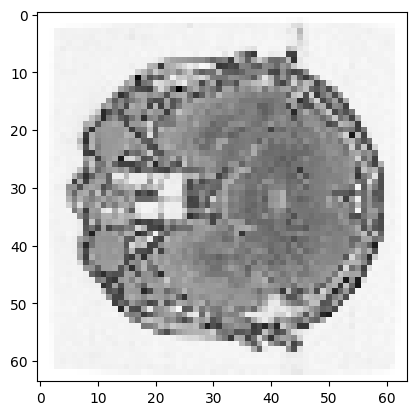

In [9]:
img = np.load("./processed/1000.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()

# 6. Image Classification

### Creating a list of labels, images and masks from processed images

In [11]:
# get processed data
folder = "./processed/"
directs = sorted(listdir(folder))


images = []
masks = []
labels = []
i = 0
for file in directs:
    try:
        data = np.load(folder+file)
        label = data["label"]
        img = np.stack((data["image"],), axis=-1)
        images.append(img)
        labels.append(label)
        i+=1
    except:
        continue

npimages = np.asarray(images)
nplabels = np.asarray(labels)

In [12]:
npimages.shape, nplabels.shape

((3049, 64, 64, 1), (3049,))

### Train-Validation-Test Split

Splitting the data to 3 parts train/validation/test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [14]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((2134, 64, 64, 1),
 (458, 64, 64, 1),
 (457, 64, 64, 1),
 (457,),
 (2134,),
 (458,))

### Defining a Fully Connected Layer with Tensorflow

In [15]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(128, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(4, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training the Model

In [16]:
### tf.random.set_seed(42)
q_model = Model()
checkpoint_path = "checkpoints/quantum.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=20,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/20
134/134 - 1s - loss: 0.9511 - accuracy: 0.6026 - val_loss: 0.5875 - val_accuracy: 0.7352
Epoch 2/20
134/134 - 1s - loss: 0.6099 - accuracy: 0.7081 - val_loss: 0.4874 - val_accuracy: 0.7768
Epoch 3/20
134/134 - 1s - loss: 0.5350 - accuracy: 0.7502 - val_loss: 0.4606 - val_accuracy: 0.8228
Epoch 4/20
134/134 - 1s - loss: 0.4838 - accuracy: 0.7793 - val_loss: 0.4857 - val_accuracy: 0.7462
Epoch 5/20
134/134 - 1s - loss: 0.4300 - accuracy: 0.8074 - val_loss: 0.5011 - val_accuracy: 0.8053
Epoch 6/20
134/134 - 1s - loss: 0.3851 - accuracy: 0.8360 - val_loss: 0.3904 - val_accuracy: 0.8206
Epoch 7/20
134/134 - 1s - loss: 0.3603 - accuracy: 0.8327 - val_loss: 0.3617 - val_accuracy: 0.8446
Epoch 8/20
134/134 - 1s - loss: 0.3663 - accuracy: 0.8435 - val_loss: 0.4254 - val_accuracy: 0.8293
Epoch 9/20
134/134 - 1s - loss: 0.3179 - accuracy: 0.8538 - val_loss: 0.3724 - val_accuracy: 0.8512
Epoch 10/20
134/134 - 1s - loss: 0.3172 - accuracy: 0.8557 - val_loss: 0.3665 - val_accuracy: 0.8337

### Saving the model

In [17]:
q_model.save('QModel.h5')

### Plotting the results

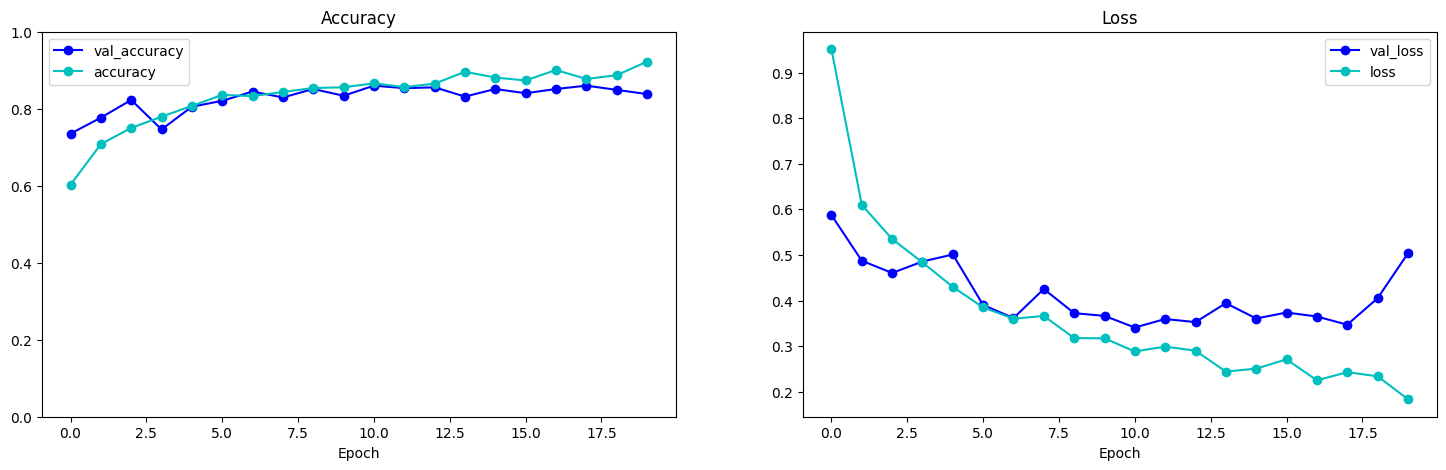

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

### Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
q_model = K.models.load_model('QModel.h5')

In [21]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [22]:
yhat.shape, y_test.shape

((458,), (458,))

In [23]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.79      0.72      0.75       113
         2.0       0.88      0.86      0.87       213
         3.0       0.87      0.98      0.93       132

    accuracy                           0.86       458
   macro avg       0.85      0.85      0.85       458
weighted avg       0.86      0.86      0.86       458



Confusion matrix, without normalization


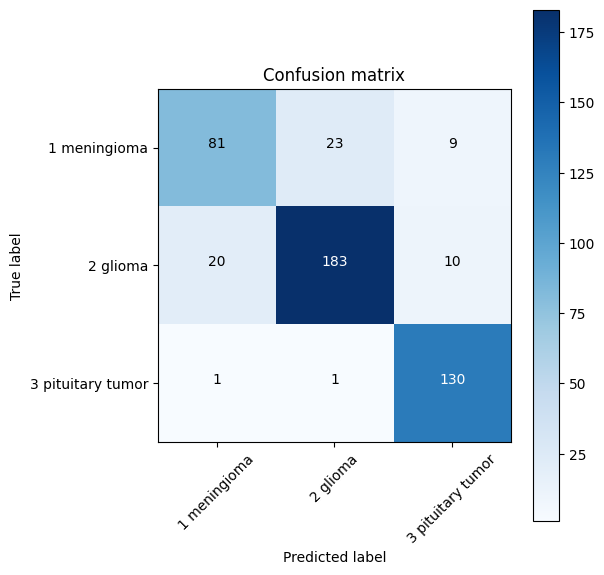

In [24]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

Observations:

1. Our Model performed really well and was able to accurately classify the images.
2. We were able to achieve an accuracy of **92%** using our model
3. The loss was comparable.

# 7. Classical Model

To compare our performance against classical computer, we will use DenseNet121 Model and see how our quantum model performed.

### Resizing the images

In [25]:
folder = "./data/" # .mat files folder

w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
images = []
labels = []

for file in directs:

    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue

    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    images.append(np.stack((resized,), axis=-1))
    labels.append(label)
    print("image "+str(k)+"  ", end="\r")

    k+=1
images = np.asarray(images)/255
labels = np.asarray(labels)

In [26]:
images.shape

(3049, 128, 128, 1)

### Train-Validation-Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2134, 128, 128, 1), (458, 128, 128, 1), (2134,), (458,))

### Creating and training on DenseNet121 Model

`Note`: I trained the model on a GPU (GTX 1650), hence I was able to train it in very short time. It's recommended to train it on a GPU as each epoch takes approximately 30 mins.

In [29]:
# create DenseNet121 Model
model = K.applications.DenseNet121(
    weights=None,
    input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    classes=4,
)
# compile the model
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
checkpoint_path = "checkpoints/classical.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=20,
    verbose=1,
    callbacks=[cp_callback]
)

Epoch 1/20
134/134 [==============================] - 21s 155ms/step - loss: 0.7462 - accuracy: 0.6649 - val_loss: 3.7907 - val_accuracy: 0.2969
Epoch 2/20
134/134 [==============================] - 15s 114ms/step - loss: 0.5678 - accuracy: 0.7404 - val_loss: 1.0291 - val_accuracy: 0.6616
Epoch 3/20
134/134 [==============================] - 16s 116ms/step - loss: 0.4975 - accuracy: 0.7737 - val_loss: 1.1085 - val_accuracy: 0.6332
Epoch 4/20
134/134 [==============================] - 15s 115ms/step - loss: 0.4703 - accuracy: 0.7938 - val_loss: 2.3088 - val_accuracy: 0.6223
Epoch 5/20
134/134 [==============================] - 16s 117ms/step - loss: 0.4520 - accuracy: 0.8083 - val_loss: 1.6101 - val_accuracy: 0.6441
Epoch 6/20
134/134 [==============================] - 16s 117ms/step - loss: 0.3860 - accuracy: 0.8313 - val_loss: 0.6482 - val_accuracy: 0.7074
Epoch 7/20
134/134 [==============================] - 16s 118ms/step - loss: 0.3738 - accuracy: 0.8351 - val_loss: 0.7952 - val_ac

### Saving the Model

In [30]:
model.save('DenseNet121.h5')

### Plotting the results

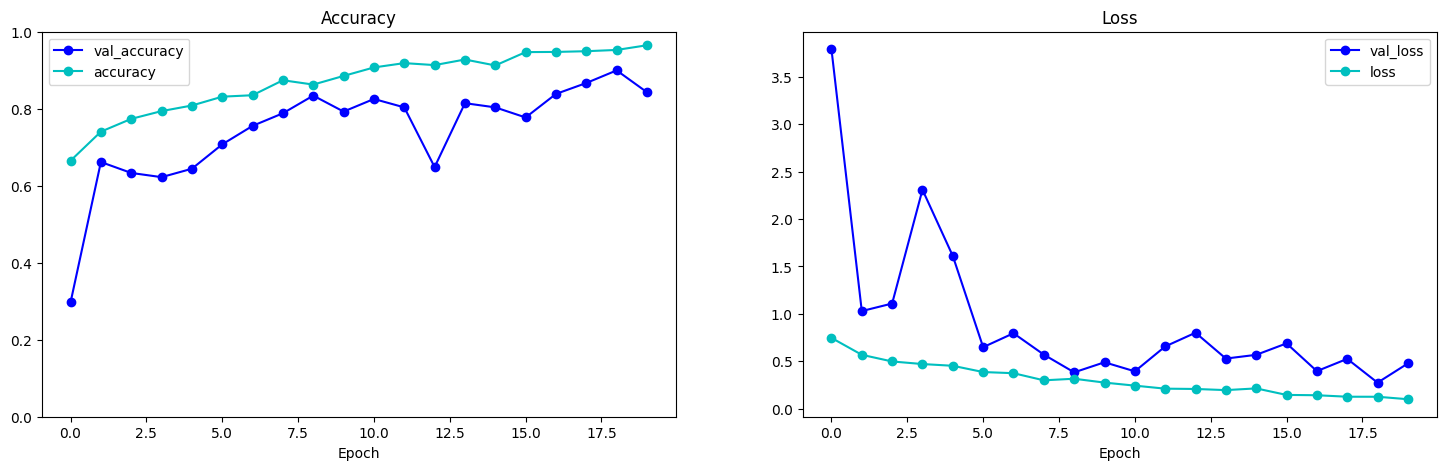

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

### Confusion Matrix

In [32]:
# Get Saved Model
model = K.models.load_model('DenseNet121.h5')

In [33]:
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [34]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.63      0.96      0.76       113
         2.0       0.99      0.72      0.83       213
         3.0       0.95      0.95      0.95       132

    accuracy                           0.84       458
   macro avg       0.86      0.87      0.85       458
weighted avg       0.89      0.84      0.85       458



Confusion matrix, without normalization


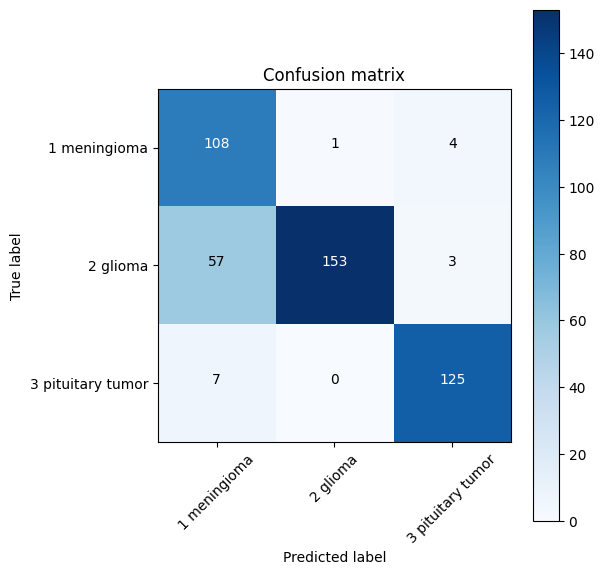

In [35]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

# 8. Conclusion

We gain some unexpected results from above.

1. Classical Model attained an accuracy of 97% whereas our quantum model attained an accuracy of 93%.
2. But expect for meningioma tumor, our quantum model was able to classify more glioma and pituitary tumor accurately compared to our classical model. (See the confusion matrix of both to better understand it)
3. This demonstration shows a perfect example of quantum advantage as a basic quantum model gave better results compared to a classical model.

Quantum Computers are still in experimental stage, but they will enable us to solve complex problems not possible on today's computers once they are ready.